## Setup

In [153]:
%matplotlib inline

In [154]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [155]:
from aif360.datasets import StandardDataset
StandardDataset??

In [156]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

## Arguments & Initializations

In [157]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_gender_aif'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [158]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [159]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [160]:
DATASET = "law_gender_aif"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [161]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [162]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [163]:
dataset_orig.features.shape

(22342, 4)

In [164]:
privileged_groups

[{'gender': 1}]

In [165]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[1.         0.         0.67567568 0.925     ]
 [0.         0.         0.64864865 0.675     ]
 [1.         1.         0.56756757 0.725     ]
 ...
 [1.         1.         0.75675676 0.775     ]
 [0.         1.         0.39189189 0.75      ]
 [1.         1.         0.82432432 0.6       ]]


In [166]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [167]:
dataset_orig_train

               instance weights features            features  features  \
                                         protected attribute             
                                    race              gender      lsat   
instance names                                                           
23657                       1.0      1.0                 0.0  0.675676   
6688                        1.0      0.0                 0.0  0.648649   
23147                       1.0      1.0                 1.0  0.567568   
12658                       1.0      1.0                 0.0  0.783784   
10884                       1.0      1.0                 1.0  0.945946   
...                         ...      ...                 ...       ...   
17156                       1.0      1.0                 1.0  0.675676   
9817                        1.0      1.0                 1.0  0.594595   
18218                       1.0      1.0                 1.0  0.756757   
20917                       1.0      0

In [168]:
dataset_orig_train?

## Run Mitigating Algorithms

In [169]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[1.         1.         0.7972973  0.8       ]
 [1.         0.         0.64864865 0.625     ]
 [1.         0.         0.78378378 0.8       ]
 ...
 [1.         0.         0.83783784 0.8       ]
 [1.         0.         0.91891892 0.9       ]
 [1.         1.         0.89189189 0.975     ]]
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
privileged vs. unprivileged:  6273.0 4898.0
base_pos unpriv:  0.2933850551245406
base_pos priv:  0.3098995695839311
number of favorable labels:  3381
Difference in mean outcomes between unprivileged and privileged groups = -0.016515
#### Train shape, validation shape, test shape
(11171

Number of training samples (ntrain): 4329
Number of test samples (ntest): 4375
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1944
Number of test samples (ntest): 1976
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.38776553100876343
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7790, Test = 7834
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.38776553100876343
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3381, Test = 3337
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.45
  

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3461
Number of test samples (ntest): 3459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1437
Number of test samples (ntest): 1361
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4329
Number of test samples (ntest): 4375
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1944
Number of test samples (ntest): 1976
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -1.3217558399823193
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7790, Test = 7834
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.04
  Positive predicti

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3461
Number of test samples (ntest): 3459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1437
Number of test samples (ntest): 1361
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4329
Number of test samples (ntest): 4375
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1944
Number of test samples (ntest): 1976
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: -0.5562879978427482
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7790, Test = 7834
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.07
  Positive predicti

Number of training samples (ntrain): 3461
Number of test samples (ntest): 3459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1437
Number of test samples (ntest): 1361
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4329
Number of test samples (ntest): 4375
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1944
Number of test samples (ntest): 1976
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.40090739897169225
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7790, Test = 7834
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.3048070897860532
Balanced accuracy is:  0.4830093713356462
Accuracy for threshold: 0.02  is: 0.3048070897860532
Balanced accuracy is:  0.4830093713356462
Accuracy for threshold: 0.03  is: 0.3048070897860532
Balanced accuracy is:  0.4830093713356462
Accuracy for threshold: 0.04  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.05  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.060000000000000005  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.06999999999999999  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.08  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.09  is: 0.30874585981559394
Balanced accuracy is:  0.4784207119424186
Accuracy for threshold: 0.09999999999999999  is: 0.30874585981559394
Balanced accuracy is:  0.4

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      3461
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96      3461
   macro avg       0.50      0.48      0.49      3461
weighted avg       1.00      0.96      0.98      3461

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.16      0.27      1437

    accuracy                           0.16      1437
   macro avg       0.50      0.08      0.14      1437
weighted avg       1.00      0.16      0.27      1437

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      4329
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97      4329
   macro avg       0.50   

C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['disp_imp'] = 1-min(classified_metric_pred.disparate_impact(), 1/classified_metric_pred.disparate_impact())
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['disp_imp'].append(1-min(classified_metric_pred.disparate_impact(), 1/classified_metric_pred.disparate_impact()))


Best balanced accuracy: 0.5110
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: -0.0783
Corresponding statistical parity difference value: -0.0720
Corresponding equal opportunity difference value: -0.0951
Corresponding Theil index value: 0.3431
Corresponding false positive_rate for privileged: 0.0615
Corresponding false negative_rate for privileged: 0.9049
Corresponding false positive_rate for unpribileged: 0.0000
Corresponding false negative_rate for unprivileged: 1.0000
#### Train dataset's features are as below:
[[1.         1.         0.52702703 0.75      ]
 [1.         1.         0.64864865 0.7       ]
 [1.         0.         0.67567568 0.8       ]
 ...
 [1.         1.         0.61351351 0.825     ]
 [0.         1.         0.55405405 0.8       ]
 [1.         0.         0.78378378 1.        ]]
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#

Number of training samples (ntrain): 3487
Number of test samples (ntest): 3433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1429
Number of test samples (ntest): 1369
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4335
Number of test samples (ntest): 4369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1920
Number of test samples (ntest): 2000
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -1.0740064778659095
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold:

Number of training samples (ntrain): 3487
Number of test samples (ntest): 3433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1429
Number of test samples (ntest): 1369
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4335
Number of test samples (ntest): 4369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1920
Number of test samples (ntest): 2000
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -0.8472978603872037
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold:

Number of training samples (ntrain): 3487
Number of test samples (ntest): 3433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1429
Number of test samples (ntest): 1369
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4335
Number of test samples (ntest): 4369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1920
Number of test samples (ntest): 2000
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: -0.34830669426821587
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold

Number of training samples (ntrain): 3487
Number of test samples (ntest): 3433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1429
Number of test samples (ntest): 1369
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4335
Number of test samples (ntest): 4369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1920
Number of test samples (ntest): 2000
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: -1.0324590411615882
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold:

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.02  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.03  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.04  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.05  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.060000000000000005  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.06999999999999999  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.08  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.09  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.09999999999999999  is: 0.31071524483036433
Balanced accuracy is:  0.4787935

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      3487
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97      3487
   macro avg       0.50      0.48      0.49      3487
weighted avg       1.00      0.97      0.98      3487

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.15      0.26      1429

    accuracy                           0.15      1429
   macro avg       0.50      0.07      0.13      1429
weighted avg       1.00      0.15      0.26      1429

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      4335
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96      4335
   macro avg       0.50   

Accuracy for threshold: 0.17  is: 0.4090949780682123
Balanced accuracy is:  0.557488170601734
Accuracy for threshold: 0.18000000000000002  is: 0.41419747560648107
Balanced accuracy is:  0.5569247871157239
Accuracy for threshold: 0.19  is: 0.4415898308119237
Balanced accuracy is:  0.5672592988425539
Accuracy for threshold: 0.2  is: 0.4505415808790619
Balanced accuracy is:  0.5684397087031364
Accuracy for threshold: 0.21000000000000002  is: 0.4574344284307582
Balanced accuracy is:  0.5706759133310492
Accuracy for threshold: 0.22  is: 0.45868767344015754
Balanced accuracy is:  0.5712358157359929
Accuracy for threshold: 0.23  is: 0.4837525736281443
Balanced accuracy is:  0.5730736933828796
Accuracy for threshold: 0.24000000000000002  is: 0.4890341061677558
Balanced accuracy is:  0.5753369096780826
Accuracy for threshold: 0.25  is: 0.5121296213409722
Balanced accuracy is:  0.5814990509013185
Accuracy for threshold: 0.26  is: 0.5220660639154955
Balanced accuracy is:  0.5837217116509843
Accur

Accuracy for threshold: 0.15000000000000002  is: 0.3982633604869752
Balanced accuracy is:  0.5519262210167664
Accuracy for threshold: 0.16  is: 0.4005908155044311
Balanced accuracy is:  0.5529178535631318
Accuracy for threshold: 0.17  is: 0.4011279205084594
Balanced accuracy is:  0.5525434376143479
Accuracy for threshold: 0.18000000000000002  is: 0.41231760809238205
Balanced accuracy is:  0.5564222369480194
Accuracy for threshold: 0.19  is: 0.41231760809238205
Balanced accuracy is:  0.5564222369480194
Accuracy for threshold: 0.2  is: 0.4299525557246442
Balanced accuracy is:  0.559771360312891
Accuracy for threshold: 0.21000000000000002  is: 0.4299525557246442
Balanced accuracy is:  0.559771360312891
Accuracy for threshold: 0.22  is: 0.434607465759556
Balanced accuracy is:  0.5625135581449726
Accuracy for threshold: 0.23  is: 0.43532360576492707
Balanced accuracy is:  0.560496471401226
Accuracy for threshold: 0.24000000000000002  is: 0.4474084683555635
Balanced accuracy is:  0.562992311

Accuracy for threshold: 0.22  is: 0.4673708710052815
Balanced accuracy is:  0.5730672258005707
Accuracy for threshold: 0.23  is: 0.46862411601468085
Balanced accuracy is:  0.5716033075672463
Accuracy for threshold: 0.24000000000000002  is: 0.4835735386268015
Balanced accuracy is:  0.5748006900377699
Accuracy for threshold: 0.25  is: 0.48876555366574165
Balanced accuracy is:  0.5739640892438096
Accuracy for threshold: 0.26  is: 0.5011189687583922
Balanced accuracy is:  0.575640277332973
Accuracy for threshold: 0.27  is: 0.51069734133023
Balanced accuracy is:  0.5769319866761717
Accuracy for threshold: 0.28  is: 0.5311968489839763
Balanced accuracy is:  0.5794647870198514
Accuracy for threshold: 0.29000000000000004  is: 0.5463253065974398
Balanced accuracy is:  0.5800919142362063
Accuracy for threshold: 0.3  is: 0.5577835466833766
Balanced accuracy is:  0.5807056117081197
Accuracy for threshold: 0.31  is: 0.574791871810939
Balanced accuracy is:  0.5800644460336943
Accuracy for threshold:

Accuracy for threshold: 0.36000000000000004  is: 0.6372750872795632
Balanced accuracy is:  0.5796822309415377
Accuracy for threshold: 0.37  is: 0.6460478023453585
Balanced accuracy is:  0.5773614341414843
Accuracy for threshold: 0.38  is: 0.6453316623399875
Balanced accuracy is:  0.5758368347682615
Accuracy for threshold: 0.39  is: 0.6674424850058186
Balanced accuracy is:  0.5679705426735265
Accuracy for threshold: 0.4  is: 0.6707546325306597
Balanced accuracy is:  0.5661254365522947
Accuracy for threshold: 0.41000000000000003  is: 0.6747829200608719
Balanced accuracy is:  0.558131276550852
Accuracy for threshold: 0.42000000000000004  is: 0.6794378300957837
Balanced accuracy is:  0.5505013936118092
Accuracy for threshold: 0.43  is: 0.6793483125951123
Balanced accuracy is:  0.5488351161414191
Accuracy for threshold: 0.44  is: 0.6858830901441232
Balanced accuracy is:  0.5426353678292869
Accuracy for threshold: 0.45  is: 0.6852564676394235
Balanced accuracy is:  0.541259180447753
Accuracy

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.02  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.03  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.04  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.05  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.060000000000000005  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.06999999999999999  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.08  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.09  is: 0.31071524483036433
Balanced accuracy is:  0.478793577523371
Accuracy for threshold: 0.09999999999999999  is: 0.31071524483036433
Balanced accuracy is:  0.4787935

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3487
Number of test samples (ntest): 3433
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1429
Number of test samples (ntest): 1369
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4335
Number of test samples (ntest): 4369
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1920
Number of test samples (ntest): 2000
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7822, Test = 7802
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predi

In [170]:
import pandas as pd
df_converted, _ = dataset_orig.convert_to_dataframe()
df_converted['gender'].value_counts()

gender
1.0    12624
0.0     9718
Name: count, dtype: int64

In [171]:
counts_ = df_converted['gender'].value_counts()

In [172]:
%matplotlib inline

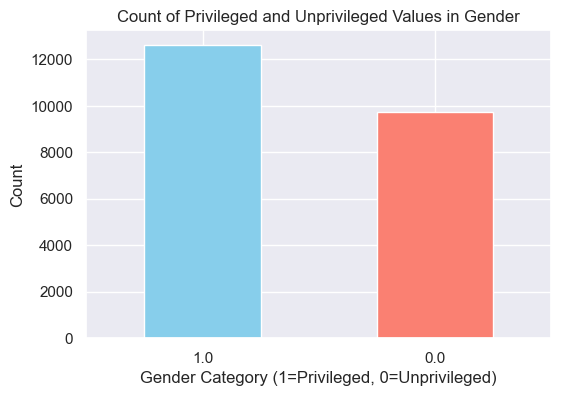

In [174]:
# Plot the bar graph
plt.figure(figsize=(6, 4))
counts_.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [175]:
df_converted.shape

(22342, 5)

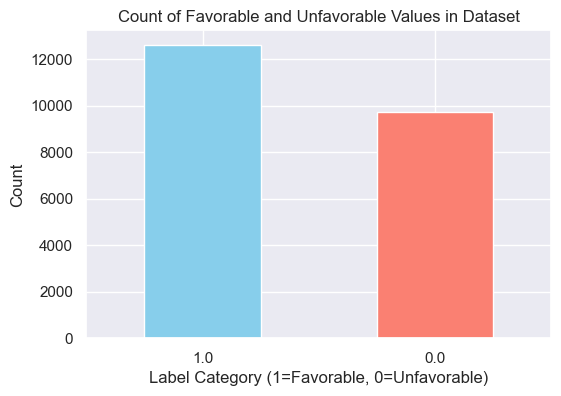

In [177]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_converted['gpa_class'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
counts_.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Display Output

In [178]:
priv_metric_orig_copy = priv_metric_orig

In [179]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 18783.0, 'total_unpriv': 14730.0})

In [180]:
priv_metric_orig

defaultdict(float, {'total_priv': 18783.0, 'total_unpriv': 14730.0})

In [181]:
priv_metric_orig = priv_metric_orig_copy

1)

law_gender_aif
11171
2)

              total_priv  total_unpriv
num_instance                          
orig              6261.0        4910.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.300749       0.699251    0.307936      0.692064      0.291584   
transf      0.307915       0.692085    0.307936      0.692064      0.307888   

         unpriv_unfavor  
dataset                  
orig           0.708416  
transf         0.692112  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.587099      -0.055766  0.123265      -0.072909   
dt_syn                     0.523684       0.035577  0.317148       0.027954   
dt_dir                     0.583443      -0.045669  0.126382      -0.060083   
dt_rew                     0.5

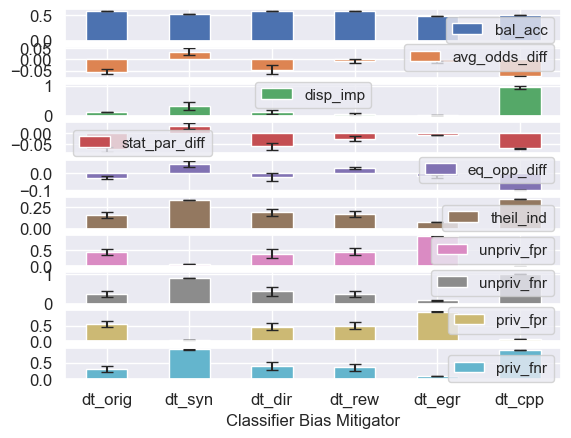

In [182]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

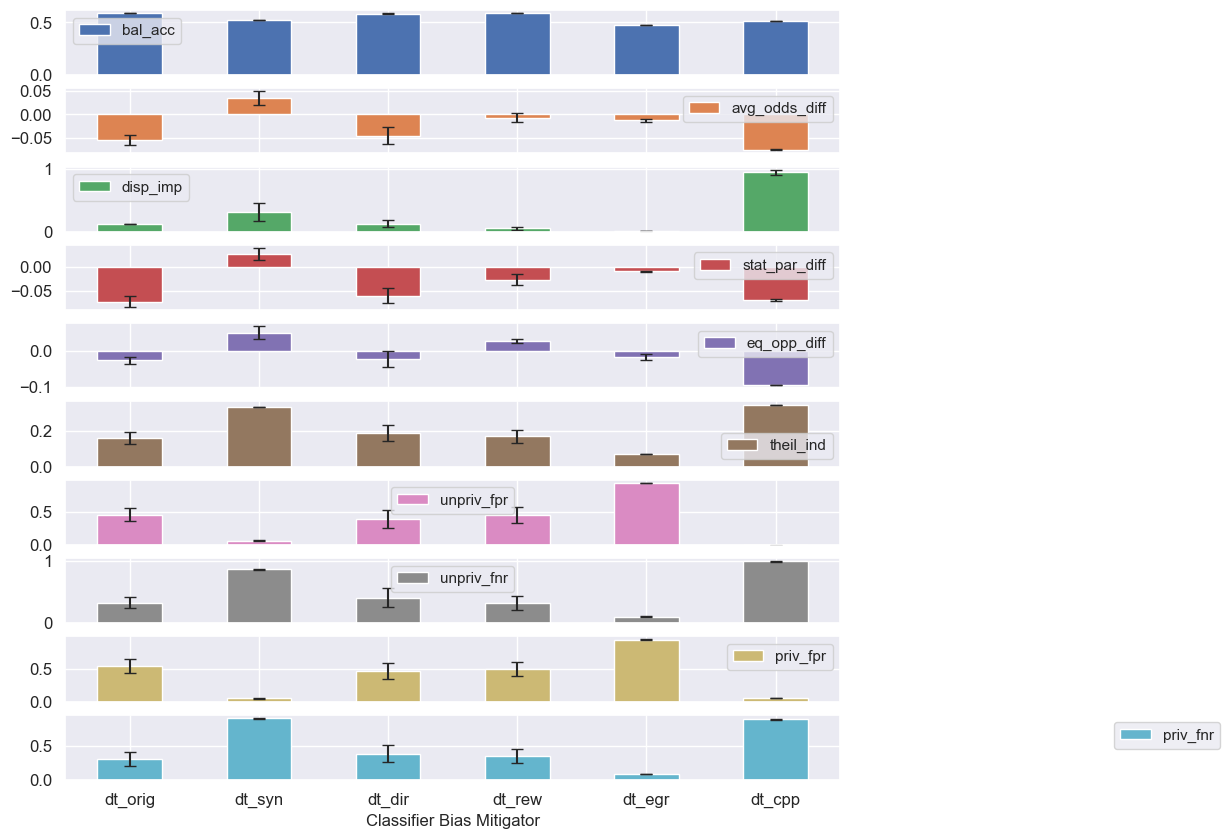

In [183]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [184]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.587099,-0.055766,0.123265,-0.072909,-0.025892,0.159569,0.460936,0.332312,0.546577,0.306420
dt_syn,0.523684,0.035577,0.317148,0.027954,0.050874,0.332372,0.067711,0.866087,0.047430,0.916961
dt_dir,0.583443,-0.045669,0.126382,-0.060083,-0.022015,0.186149,0.396409,0.410982,0.465733,0.388968
dt_rew,0.587569,-0.007135,0.052073,-0.026447,0.027912,0.167842,0.459020,0.325682,0.501202,0.353594
dt_egr,0.478669,-0.012264,0.009508,-0.008892,-0.017465,0.072322,0.940242,0.108821,0.947305,0.091356
dt_cpp,0.512225,-0.076349,0.949096,-0.069329,-0.095151,0.344434,0.003690,0.996104,0.061237,0.900953


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [185]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [186]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.516695,0.516071,0.540665,0.516060,0.534545,0.519806,0.547872
syn,0.516799,0.514792,0.539215,0.515627,0.535189,0.517571,0.543493
dir,0.524737,0.533739,0.545839,0.528043,0.550680,0.547740,0.545443
rew,0.516949,0.517699,0.538131,0.514911,0.534417,0.521937,0.543205
egr,0.514770,0.511088,0.524409,0.513544,0.521416,0.509193,0.526617


In [187]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [188]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [189]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.516060,0.534545,0.519806,0.547872
syn,0.515627,0.535189,0.517571,0.543493
dir,0.528043,0.550680,0.547740,0.545443
rew,0.514911,0.534417,0.521937,0.543205
egr,0.513544,0.521416,0.509193,0.526617


<Axes: xlabel='Classifier MIA Attacks'>

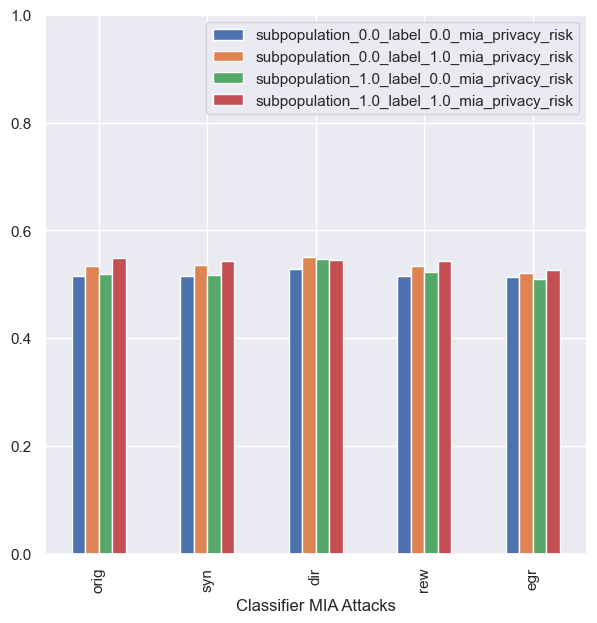

In [190]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [191]:
# Tabular Format
# importing the modules
from tabulate import tabulate

# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.51606   0.515627  0.528043  0.514911  0.513544
subpopulation_0.0_label_1.0_mia_privacy_risk  0.534545  0.535189  0.55068   0.534417  0.521416
subpopulation_1.0_label_0.0_mia_privacy_risk  0.519806  0.517571  0.54774   0.521937  0.509193
subpopulation_1.0_label_1.0_mia_privacy_risk  0.547872  0.543493  0.545443  0.543205  0.526617


### Visualizing using novel technique

In [119]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [120]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [121]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517502
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.685554
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.694673
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.516603
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517817


In [122]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517502
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.682148
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.679851
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.516603
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517817


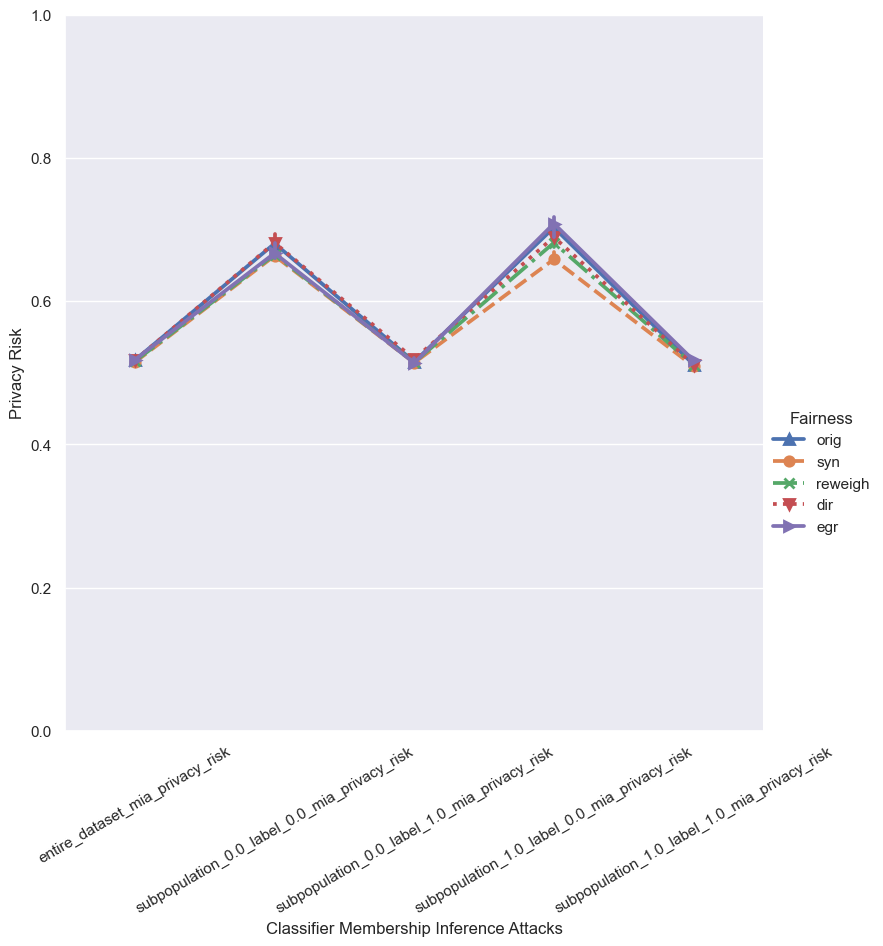

In [123]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [124]:
from sklearn.metrics import RocCurveDisplay, auc

In [125]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

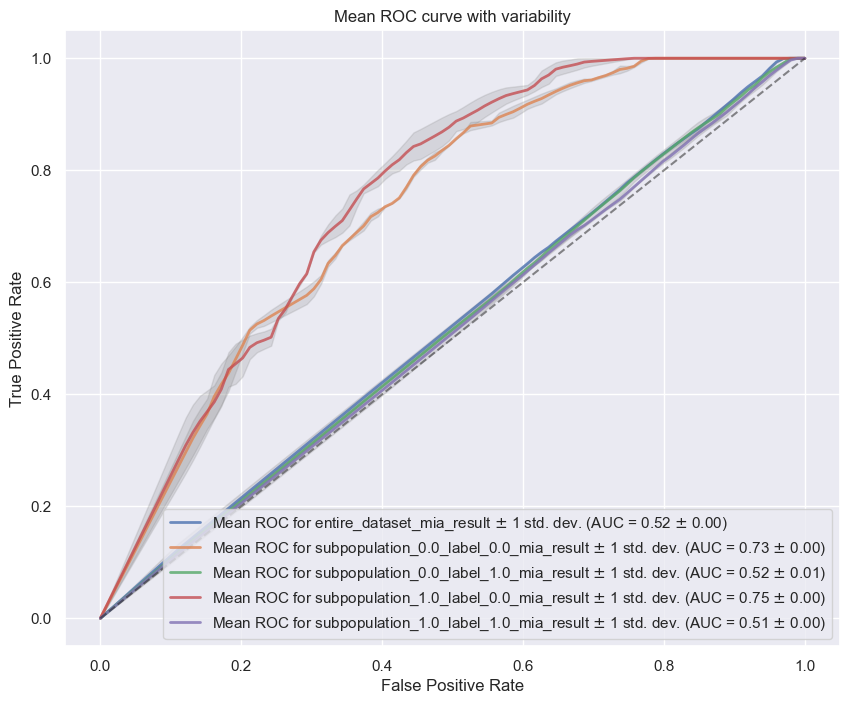

In [126]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

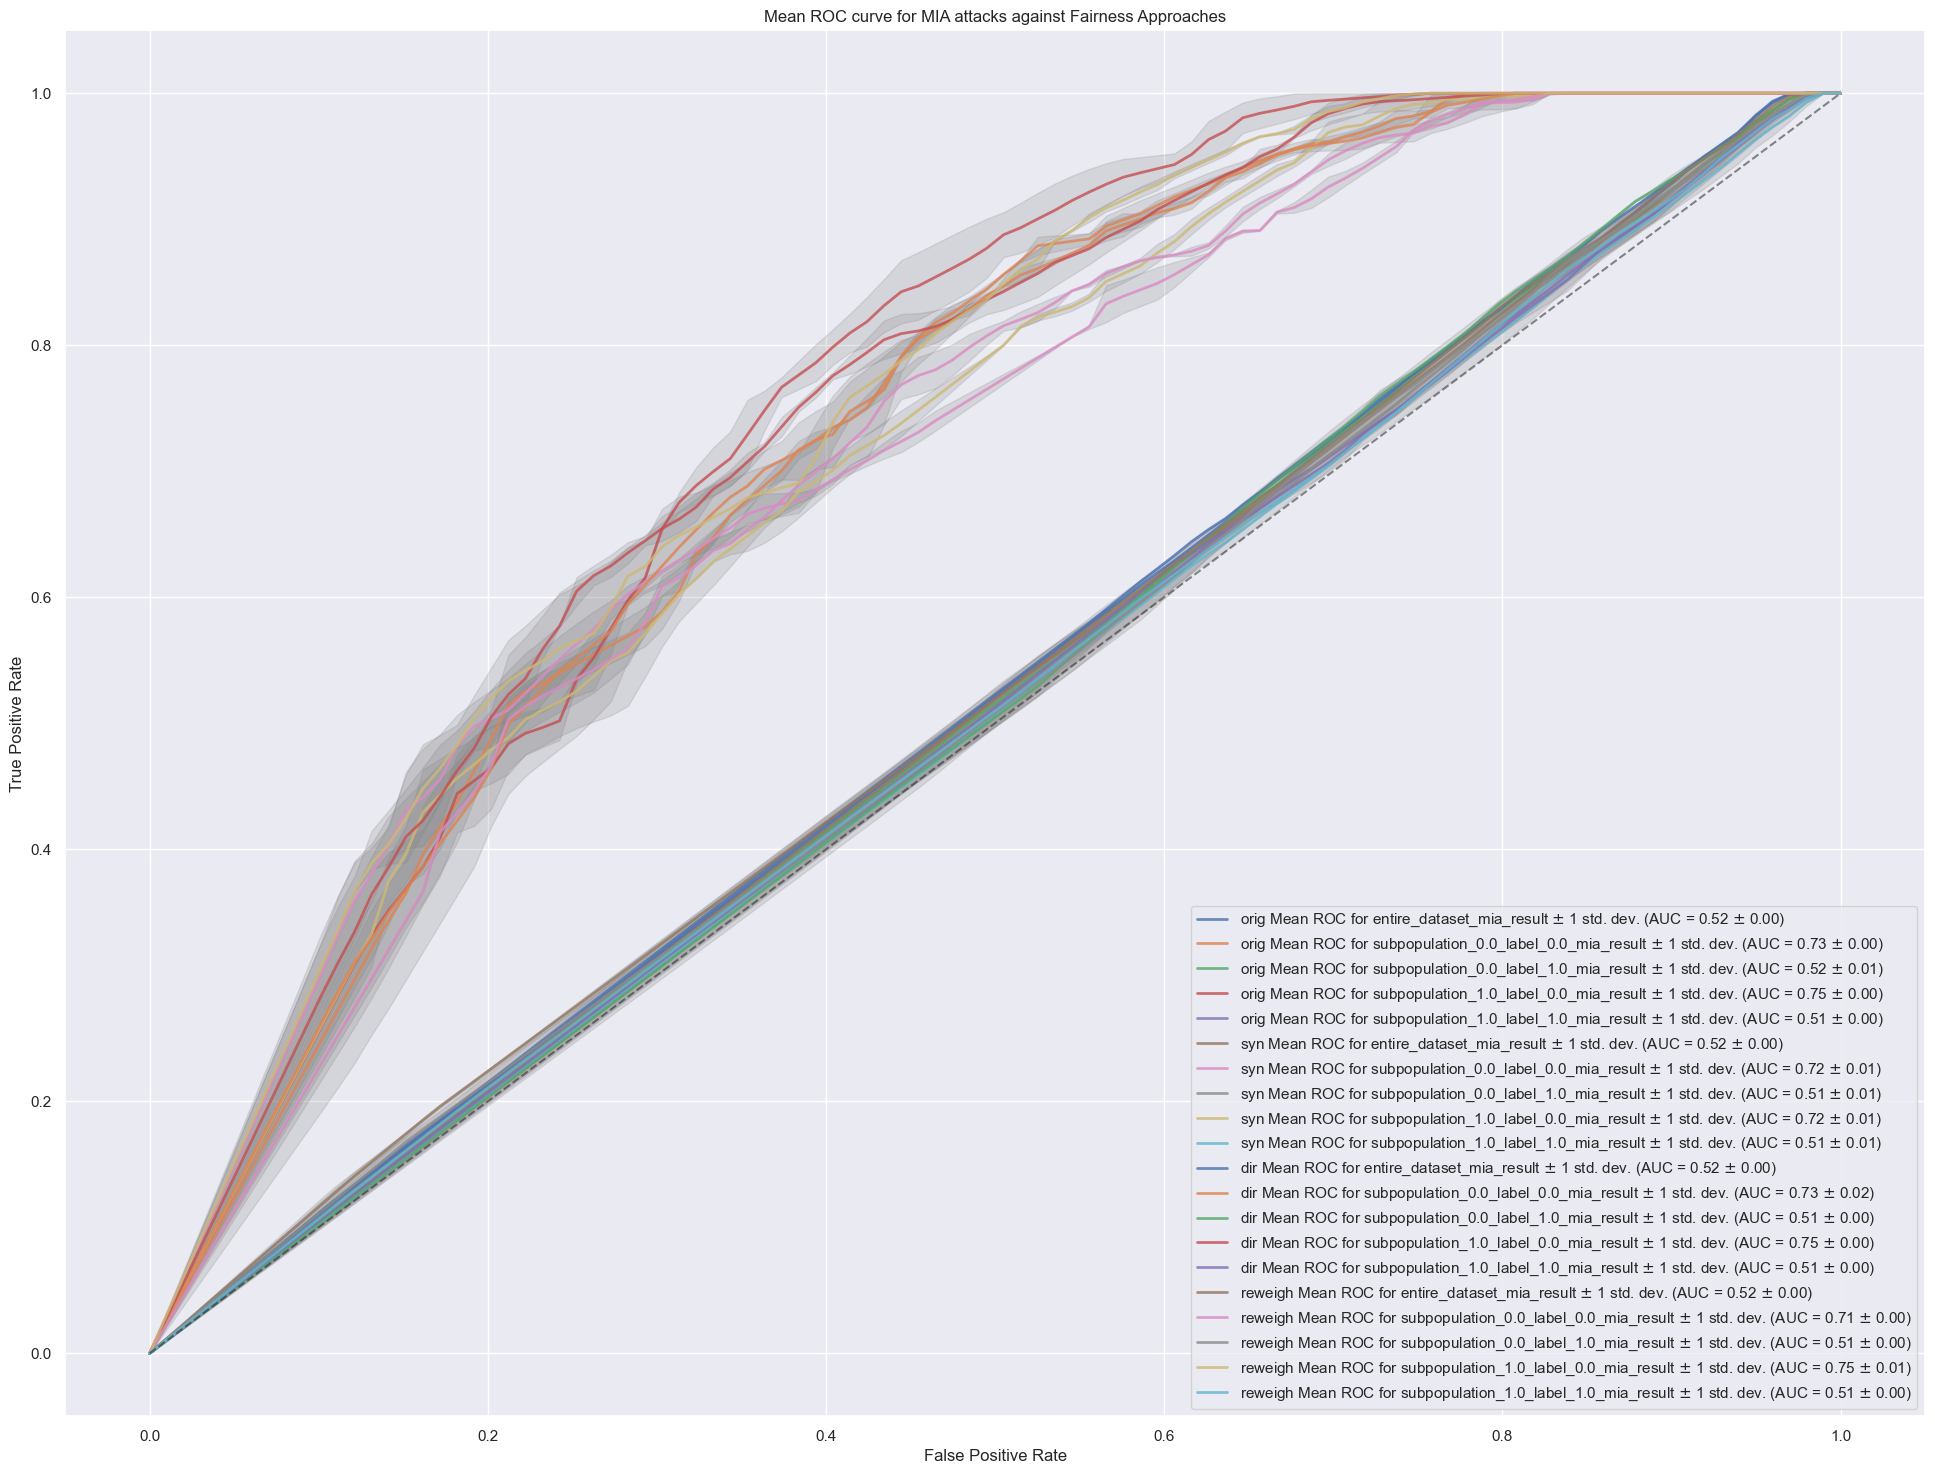

In [127]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

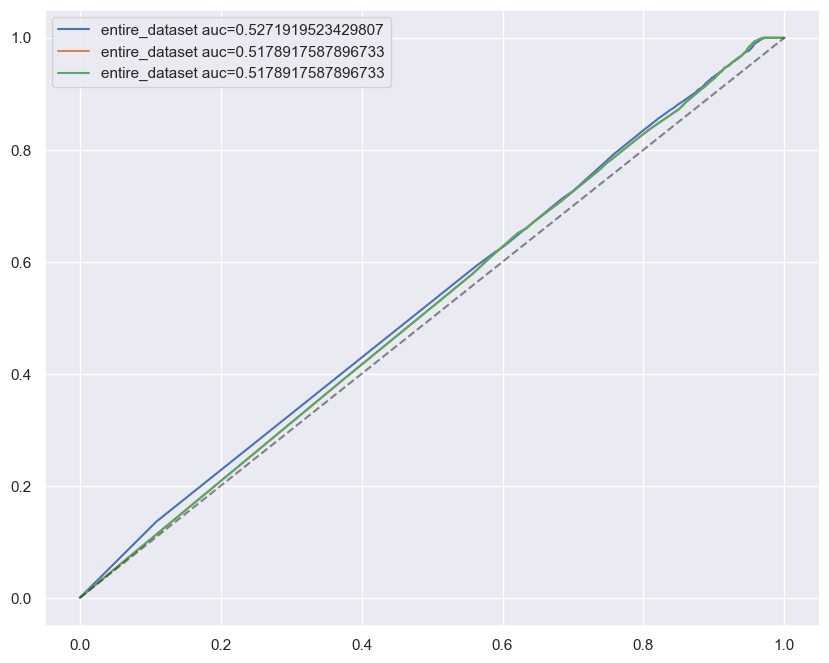

In [128]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [129]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [130]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5209918233074425,
 'entire_dataset_label_0.0_mia_auc': 0.73876466875132,
 'entire_dataset_label_1.0_mia_auc': 0.5129049647626014,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7299623974811725,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5161244493195696,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7486334197125549,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5100748314178664}

In [131]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.520992,0.738765,0.512905,0.729962,0.516124,0.748633,0.510075
syn,0.516002,0.717526,0.508727,0.717743,0.510843,0.717341,0.506994
dir,0.520239,0.738356,0.512357,0.730574,0.513995,0.745262,0.511234
rew,0.521623,0.730351,0.512855,0.712942,0.514641,0.745871,0.511211


<Axes: xlabel='Classifier MIA Attacks'>

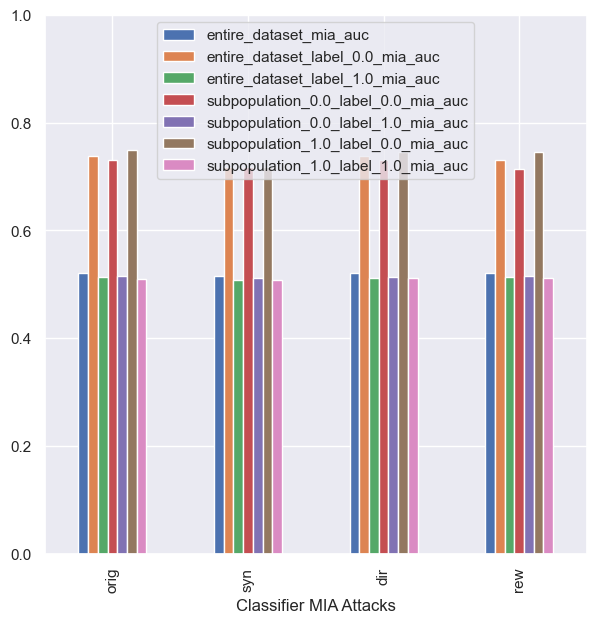

In [132]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [133]:
# Creating data structures to plot point categorical plot from seaborn

In [134]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [135]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03500336570824125,
  0.03596499663429176,
  0.03596499663429176],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.37110871647509575,
  0.3893451720310766,
  0.3893451720310766],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.03109135369927951,
  0.020981009583312615,
  0.020981009583312615],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.3642960366509854,
  0.3597015826990456,
  0.3597015826990456],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.04231206396223719,
  0.024920396627058805,
  0.024920396627058805],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.38488158163712294,
  0.41659652279917564,
  0.41659652279917564],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.027309734513274342,
  0.021357220130651555,
  0.021357220130651555]}

In [136]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03500336570824125],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset_label_0.0', 0.37110871647509575],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_1.0', 0.03109135369927951],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3642960366509854],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3597015826990456],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3597015826990456],
 ['orig', 'subpopulation_0.0_label_1.0', 0.04231206396223719],
 ['orig', 'subpopulation_0.0_label_1.0', 0.024920396627058805],
 ['orig', 'subpopulation_0.0_label_1.0', 0.024920396627058805],
 ['orig', 'subpopulation_1.0_label_0.0', 0.38488158163712294],
 ['orig', 'subpopulation_1.0_label_0.0', 0.4165965

In [137]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.035003
1,orig,entire_dataset,0.035965
2,orig,entire_dataset,0.035965
3,orig,entire_dataset_label_0.0,0.371109
4,orig,entire_dataset_label_0.0,0.389345
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.436232
101,egr,subpopulation_1.0_label_0.0,0.436232
102,egr,subpopulation_1.0_label_1.0,0.033205
103,egr,subpopulation_1.0_label_1.0,0.035635


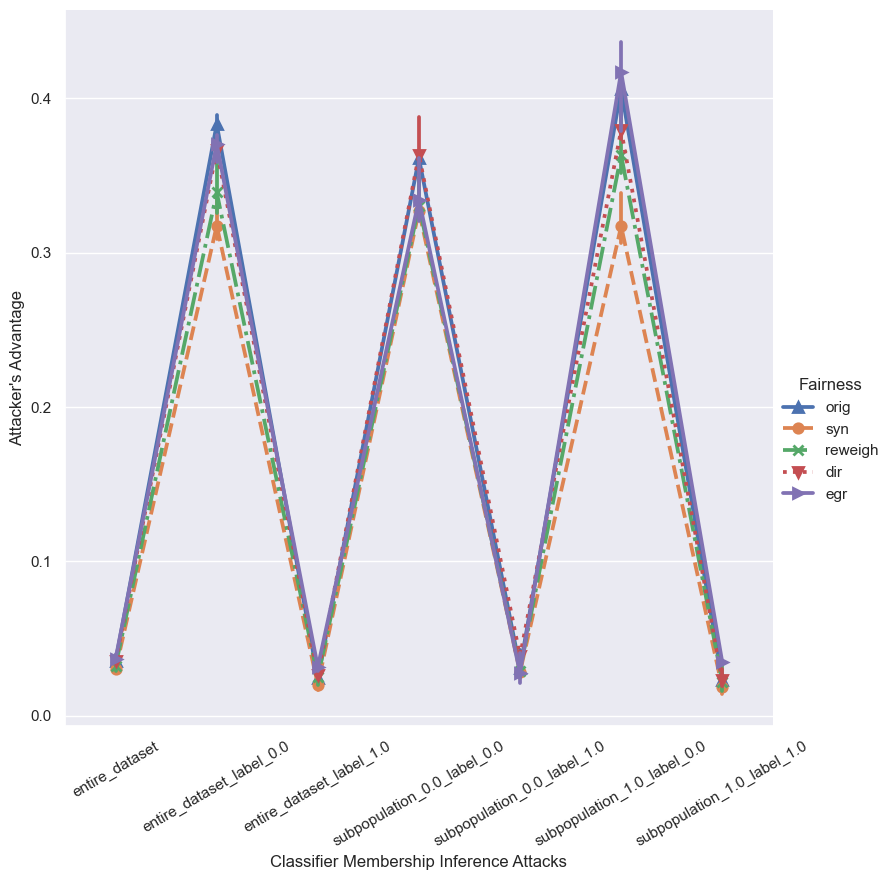

In [138]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


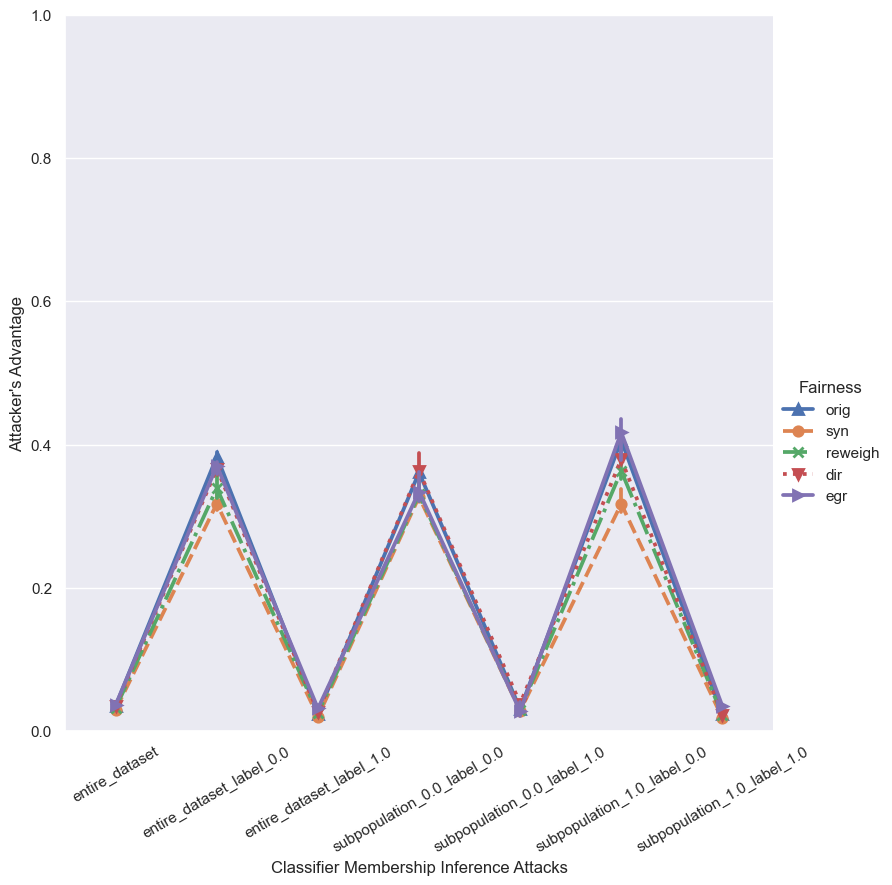

In [139]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [140]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.035003,0.371109,0.031091,0.364296,0.042312,0.384882,0.027310
1,0.035965,0.389345,0.020981,0.359702,0.024920,0.416597,0.021357
2,0.035965,0.389345,0.020981,0.359702,0.024920,0.416597,0.021357


In [141]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [142]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03564445299227492,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.38326635351241634,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.024351124288634913,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.36123306734969224,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.030717619072118268,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.4060248757451581,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.023341391591525817}

In [143]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.035644,0.383266,0.024351,0.361233,0.030718,0.406025,0.023341
syn,0.029971,0.317529,0.020141,0.327102,0.028206,0.317216,0.018300
dir,0.035228,0.366609,0.026329,0.363417,0.038469,0.379468,0.023085
rew,0.032375,0.339143,0.024798,0.330426,0.029270,0.363376,0.022125
egr,0.036895,0.370463,0.031521,0.334361,0.027634,0.417056,0.034825


<Axes: xlabel='Classifier MIA Attacks'>

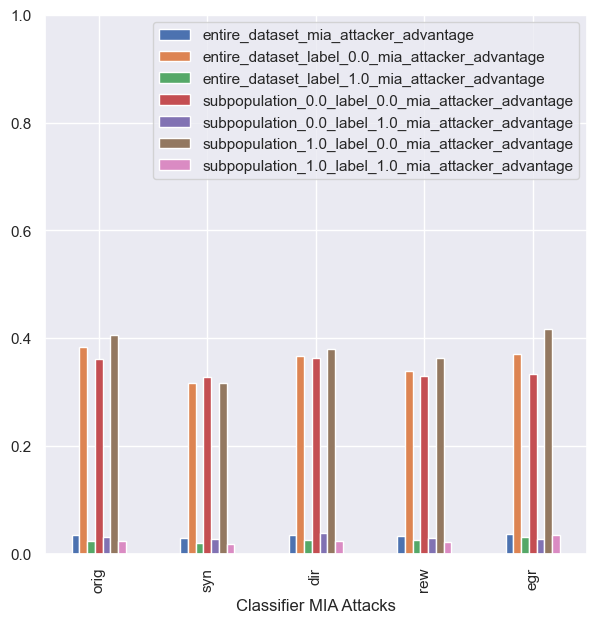

In [144]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [145]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [146]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5560361777428234],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset_label_0.0', 0.7859778597785978],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_1.0', 0.5292050944224858],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7891566265060241],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7219251336898396],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7219251336898396],
 ['orig', 'subpopulation_0.0_label_1.0', 0.53502538071066],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5007407407407407],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5007407407407407],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7890625],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7058823529411765],
 ['orig', 'subpo

In [147]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.556036
1,orig,entire_dataset,0.511522
2,orig,entire_dataset,0.511522
3,orig,entire_dataset_label_0.0,0.785978
4,orig,entire_dataset_label_0.0,0.711712
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.813559
101,egr,subpopulation_1.0_label_0.0,0.813559
102,egr,subpopulation_1.0_label_1.0,0.501796
103,egr,subpopulation_1.0_label_1.0,0.513895


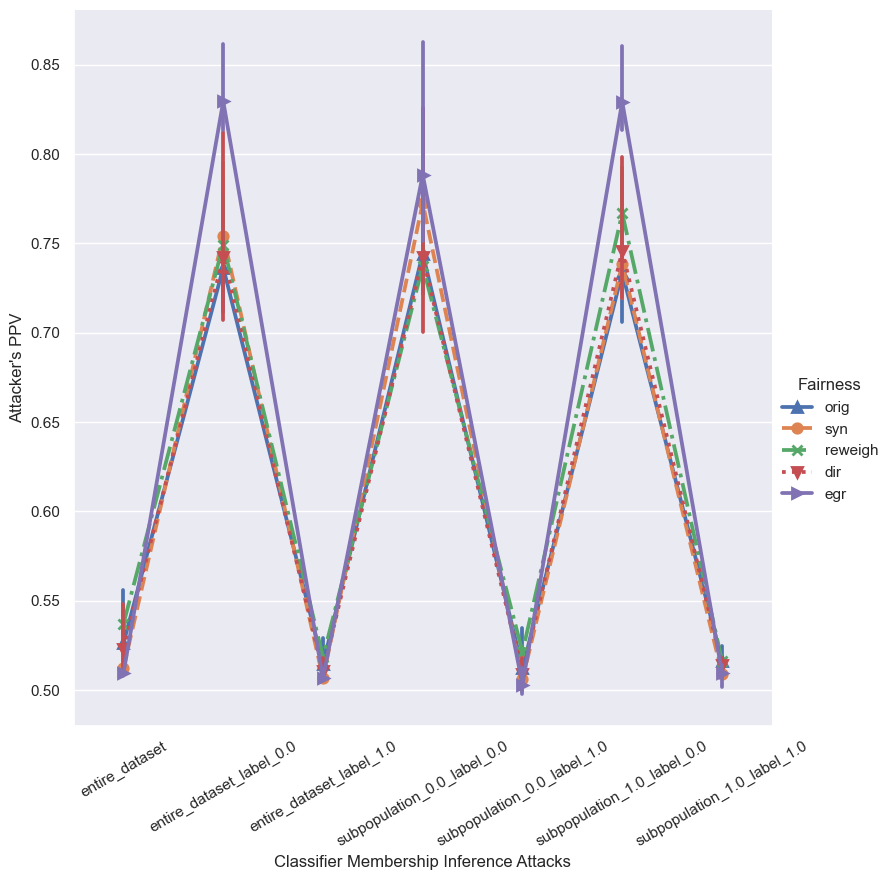

In [148]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [149]:
import pandas as pd

In [150]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,gender,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,0.0,1.0,44.0,3.5,69.0,1.0,5.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,0.0,2.0,29.0,3.5,69.0,1.0,4.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,0.0,1.0,37.0,3.4,68.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0
3,7.0,8.0,0.0,1.0,43.0,3.3,67.0,1.0,4.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,0.0,4.0,41.0,3.3,64.0,1.0,4.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,0.0,5.0,42.0,3.0,67.0,1.0,4.0,1.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,0.0,3.0,29.5,3.5,68.0,1.0,4.0,1.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,0.0,3.0,33.0,3.1,69.0,1.0,3.0,1.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,0.0,3.0,32.0,3.0,67.0,0.0,3.0,1.0,3.0,5.0,5.0,1.0


In [151]:
df[["age", "labels"]].value_counts(normalize=True)

KeyError: "['age'] not in index"

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

In [ ]:
train_test_egr

## Distribution Visualizations

In [ ]:
import pandas as pd
df_converted, _ = dataset_orig.convert_to_dataframe()
df_converted['gender'].value_counts()

In [ ]:
df_converted
counts_ = df_converted['gender'].value_counts()

In [ ]:
%matplotlib inline

In [ ]:
# Plot the bar graph
plt.figure(figsize=(6, 4))
counts_.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_converted.shape

In [ ]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_converted['pass_bar'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
counts_.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()